In [1]:
#importing lib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ta

In [2]:
#reading the train dataframe and then prepring it by adding TA features
#removing unnecessary coloumns and also filling NaN with mean of that coloumn
dataset_train = pd.read_csv('train.csv')
dataset_train = dataset_train.drop(["Date","Turnover (Lacs)"], axis=1)
RSI=ta.momentum.rsi(close=dataset_train['Close'])
MFI=ta.volume.money_flow_index(dataset_train['High'], dataset_train['Low'], dataset_train['Close'], dataset_train['Total Trade Quantity'],n=14)
dataset_train["RSI"]= RSI
dataset_train["MFI"]=MFI
values={'RSI':RSI.mean(),'MFI': MFI.mean()}
dataset_train=dataset_train.fillna(value=values)
dataset_train.head()

,Open,High,Low,Last,Close,Total Trade Quantity,RSI,MFI
0,88.00,88.00,70.00,75.55,75.55,232535736,55.473297,57.374425
1,76.80,78.60,75.00,75.15,75.20,68865277,55.473297,57.374425
2,75.10,76.10,74.55,75.25,75.30,37460886,55.473297,57.374425
3,75.50,75.95,75.00,75.05,75.05,17413433,55.473297,57.374425
4,75.35,75.40,74.30,74.60,74.45,15961426,55.473297,57.374425


In [3]:
dataset_train.describe()

,Open,High,Low,Last,Close,Total Trade Quantity,RSI,MFI
count,800.000000,800.000000,800.000000,800.000000,800.000000,8.000000e+02,800.000000,800.000000
mean,131.235437,133.455562,128.875688,131.093313,131.098125,5.691422e+06,55.473297,57.374425
std,44.417573,45.820079,43.184858,44.566984,44.532530,9.910443e+06,10.636370,15.296299
min,73.600000,74.800000,70.000000,73.500000,73.550000,1.491530e+05,21.731330,14.133205
25%,97.250000,98.200000,95.787500,96.975000,97.025000,2.057729e+06,48.206571,46.139323
50%,126.000000,127.000000,124.175000,125.250000,125.425000,3.606512e+06,56.167474,58.023406
75%,151.000000,152.975000,148.425000,150.275000,150.425000,6.470760e+06,63.011632,68.074236
max,289.000000,290.750000,271.150000,286.850000,284.650000,2.325357e+08,79.905341,97.726577


In [4]:
#drop close coloumn to find out correlation wih others
check=dataset_train.drop(['Close'],axis=1)

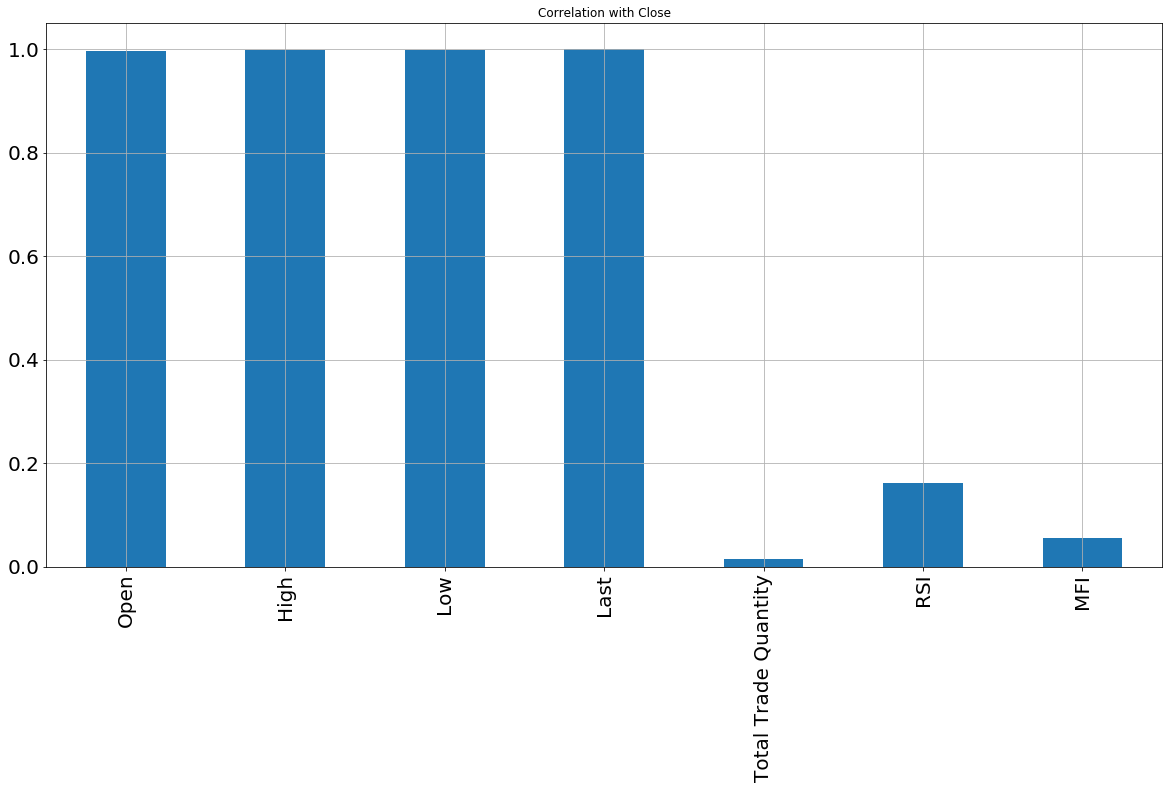

In [5]:
#checking the correlation
check.corrwith(dataset_train['Close']).plot.bar(
        figsize = (20, 10), title = "Correlation with Close", fontsize = 20,rot = 90, grid = True)

In [6]:
#from our dataframe taking all the values into an array
training_set = dataset_train.iloc[:,:].values

In [7]:
#here that data is normalized
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [8]:
#converting data into time steps 
#then reshaping them into 3d array (sample,time steps,features).
X_trainF = []
y_trainF = []
for i in range(60, 800):
    X_trainF.append(training_set_scaled[i-60:i])
X_trainF, y_trainF = np.array(X_trainF), training_set_scaled[60:]
X_trainF = np.reshape(X_trainF, (X_trainF.shape[0], X_trainF.shape[1], 8))

In [9]:
#importing necessary libs for lstm execution
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.
C:\Users\HI\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\HI\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\HI\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\HI\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: Future

In [10]:
#made a lstm model of 2 layers,adam optimizer and mean_squared_error as loss.
regressorF = Sequential()

regressorF.add(LSTM(units = 60, return_sequences = True, input_shape = (X_trainF.shape[1], 8)))
regressorF.add(Dropout(0.2))

regressorF.add(LSTM(units = 60))
regressorF.add(Dropout(0.2))

regressorF.add(Dense(units = 8))

regressorF.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressorF.fit(X_trainF, y_trainF, epochs = 1000, batch_size = 60)


Epoch 1/1000
740/740 [==============================] - 3s 4ms/step - loss: 0.0690
Epoch 2/1000
740/740 [==============================] - 1s 2ms/step - loss: 0.0178
Epoch 3/1000
740/740 [==============================] - 2s 3ms/step - loss: 0.0128
Epoch 4/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0113
Epoch 5/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0106
Epoch 6/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0103
Epoch 7/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0098
Epoch 8/1000
740/740 [==============================] - 2s 3ms/step - loss: 0.0088
Epoch 9/1000
740/740 [==============================] - 2s 3ms/step - loss: 0.0094
Epoch 10/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0086
Epoch 11/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0082
Epoch 12/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0080


740/740 [==============================] - 2s 2ms/step - loss: 0.0025
Epoch 193/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0024
Epoch 194/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0024
Epoch 195/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0024
Epoch 196/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0024
Epoch 197/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0024
Epoch 198/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0024
Epoch 199/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0023
Epoch 200/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0023
Epoch 201/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0023
Epoch 202/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0024
Epoch 203/1000
740/740 [==============================] - 1s 2ms/step - loss: 0.

740/740 [==============================] - 2s 2ms/step - loss: 0.0018
Epoch 385/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0019
Epoch 386/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0020
Epoch 387/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0019
Epoch 388/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0019
Epoch 389/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0019
Epoch 390/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0019
Epoch 391/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0020
Epoch 392/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0018
Epoch 393/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0019
Epoch 394/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0019
Epoch 395/1000
740/740 [==============================] - 1s 2ms/step - loss: 0.

740/740 [==============================] - 2s 2ms/step - loss: 0.0017
Epoch 577/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0017
Epoch 578/1000
740/740 [==============================] - 1s 2ms/step - loss: 0.0017
Epoch 579/1000
740/740 [==============================] - 1s 2ms/step - loss: 0.0017
Epoch 580/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0018
Epoch 581/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0016
Epoch 582/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0017
Epoch 583/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0016
Epoch 584/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0017
Epoch 585/1000
740/740 [==============================] - 1s 2ms/step - loss: 0.0017
Epoch 586/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0016
Epoch 587/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.

740/740 [==============================] - 2s 2ms/step - loss: 0.0016
Epoch 673/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0016
Epoch 674/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0015
Epoch 675/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0016
Epoch 676/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0017
Epoch 677/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0015
Epoch 678/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0015
Epoch 679/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0016
Epoch 680/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0016
Epoch 681/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0016
Epoch 682/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0015
Epoch 683/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.

740/740 [==============================] - 2s 2ms/step - loss: 0.0014
Epoch 865/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0014
Epoch 866/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0014
Epoch 867/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0013
Epoch 868/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0013
Epoch 869/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0015
Epoch 870/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0014
Epoch 871/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0014
Epoch 872/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0013
Epoch 873/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0013
Epoch 874/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.0014
Epoch 875/1000
740/740 [==============================] - 2s 2ms/step - loss: 0.

In [11]:
#testing data 
#similar changes are made as that of the train data.
dataset_test = pd.read_csv('test.csv')
dataset_date = pd.read_csv('dates.csv')
date=dataset_date.iloc[:, :1].values
dataset_test = dataset_test.drop(["Date","Turnover (Lacs)"], axis=1)
RSI=ta.momentum.rsi(close=dataset_test['Close'])
MFI=ta.volume.money_flow_index(dataset_test['High'], dataset_test['Low'], dataset_test['Close'], dataset_test['Total Trade Quantity'],n=14)
dataset_test["RSI"]= RSI
dataset_test["MFI"]=MFI
values1={'RSI':RSI.mean(),'MFI': MFI.mean()}
dataset_test=dataset_test.fillna(value=values1)

In [12]:
#new features :D
#this will take the test data till now and predict it for the future.
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total)-len(dataset_test)-60:].values
inputsF1 = inputs
for i in range(360,500):
    inputsF2 = inputsF1.reshape(-1,8)
    inputsF3 = sc.transform(inputsF2)
    X_test = []
    for a in range(60, i):
        X_test.append(inputsF3[a-60:a])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],8))
    predicted_stock_price = regressorF.predict(X_test)
    predicted_stock_price_next=predicted_stock_price[i-61,:]
    A=predicted_stock_price_next.reshape(-1,8)
    predicted_stock_price = sc.inverse_transform(A)
    inputsF1 =np.concatenate((inputsF1, predicted_stock_price))    

In [13]:
#extracting predicted values
predicted_stock_price1=inputsF1[360:]

In [14]:
#wanna know what would the future price gona be
#ENTER_DATE_FOR_PREDICTION
HERE='12-07-09'

In [15]:
#execute this to know the price
pridicted_prices=[]
date = date.reshape(-1)
pridicted_prices = [date,predicted_stock_price1[:,4]]
date_to_price=map(date,pridicted_prices)
for i in range(300):
    if HERE==date[i]:
        price=[row[i] for row in pridicted_prices]
        print(price)

['12-07-09', 249.59182739257812]


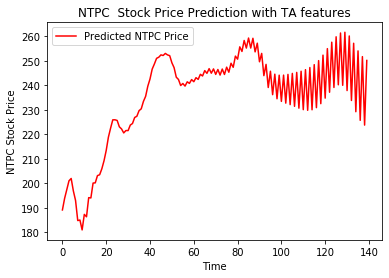

In [16]:
#A graphical presentation of how the stock prices are gona be 
plt.plot(predicted_stock_price1[:,4], color = 'red', label = 'Predicted NTPC Price')
plt.title('NTPC  Stock Price Prediction with TA features')
plt.xlabel('Time')
plt.ylabel('NTPC Stock Price')
plt.legend()
plt.show()

In [17]:
#For theoretical calculations,the predicted prices are campared with actual prices which we have.
#read the future values which are kept in another csv file
dataset_future_test = pd.read_csv('future test.csv')
real_stock_price1 = dataset_future_test.iloc[:, 5:6].values
print(real_stock_price1.shape)

(140, 1)


In [18]:
#residue is found from the real and predicted prices
estimation_residue=(real_stock_price1-predicted_stock_price1[:,4])
estimation_residue.mean()

-29.25352735246931

In [19]:
#estimated percentage of those two. 
estimation_percentage=(real_stock_price1/predicted_stock_price1[:,4])
estimation_percentage.mean()

0.8823939731099962

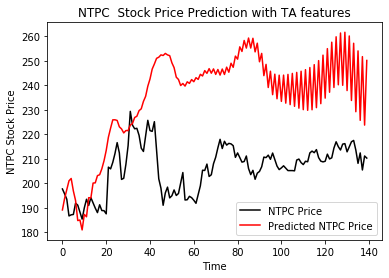

In [20]:
plt.plot(real_stock_price1, color = 'black', label = 'NTPC Price')
plt.plot(predicted_stock_price1[:,4], color = 'red', label = 'Predicted NTPC Price')
plt.title('NTPC  Stock Price Prediction with TA features')
plt.xlabel('Time')
plt.ylabel('NTPC Stock Price')
plt.legend()
plt.show()